In [1]:
import os
import cv2
import argparse
import magnum as mn
import quaternion
import matplotlib.pyplot as plt
from PIL import Image
from habitat_sim.utils import common as utils
from habitat_sim.utils.data import ImageExtractor
from habitat.utils.visualizations import maps, fog_of_war
from helpers import *
from sim import *
from config import *
from mapper import make_global_map, get_mesh_occupancy, recolor_map
# from sensors import save_observations, save_map_observations, save_poses
# from sem_map import make_sem_topdown, get_sem_occupancy
from geometry_utils import *

In [11]:
# get all validation scenes
validation_scenes =  os.listdir("/scratch/shantanu/results_23022022/occant_rgb/dump/0/")
print(validation_scenes)

['Pablo', 'Elmira', 'Sisters', 'Eudora', 'Ribera', 'Denmark', 'Swormville', 'Cantwell', 'Mosquito', 'Scioto', 'Edgemere', 'Eastville', 'Sands', 'Greigsville']


In [15]:
sim.close()

In [16]:
path = "/scratch/entropy_moving_average_global_maps/gibson"
scene = "Pablo"

sim = make_sim(path,scene)

I0227 01:11:52.760564 29536 simulator.py:221] Loaded navmesh /scratch/entropy_moving_average_global_maps/gibson/Pablo.navmesh


In [17]:
top_down_map = make_global_map(sim)
grid_dimension = (top_down_map.shape[0],top_down_map.shape[1])

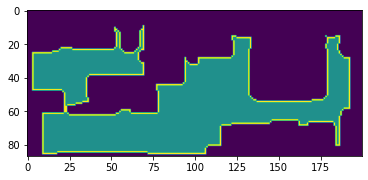

In [18]:
plt.imshow(top_down_map)

In [48]:
# Beta : momentum for moving average update
beta = 0.5 ##
threshold_explored = 0.6##
threshold_entropy = 0.5 ##
EPS_MAPPER = 1e-6
s = 0.05
LOCAL_MAP_SIZE = 128##
OUTMAP_SIZE = 1024##
MAP_THRESHOLD = 0.3

In [4]:
sim = None
LOCAL_MAP_DIR  = None
POSE_DIR  = None
GT_MAP_DIR  = None
PROB_DIR = None

top_down_map = None
grid_dimension = None
m_probs=[]

In [69]:
path = "/scratch/jd_entropy_ma_reg/entropy_moving_average_global_maps/gibson"
scene = "Cantwell"
if sim != None:
    sim.close()
sim = make_sim(path,scene)

I0228 18:07:56.039366 2675 simulator.py:221] Loaded navmesh /scratch/jd_entropy_ma_reg/entropy_moving_average_global_maps/gibson/Cantwell.navmesh


In [54]:
def get_padded_map(m,p):
    V = p.shape[1]
    MH = m.shape[2]
    MV = m.shape[1]
    Vby2 = (V - 1) // 2 if V % 2 == 1 else V // 2
    Mhby2 = (MH - 1) // 2 if MH % 2 == 1 else MH // 2
    Mvby2 = (MV - 1) // 2 if MV % 2 == 1 else MV // 2
    
    # The agent stands at the bottom-center of the egomap and looks upward
    left_h_pad = Mvby2 - V + 1
    right_h_pad = MV - V - left_h_pad
    left_w_pad = Mhby2 - Vby2
    right_w_pad = MV - V - left_w_pad
    
    if(left_h_pad < 0):
        left_h_pad = 0
        right_h_pad = MV - V - left_h_pad
    if(left_w_pad < 0):
        left_w_pad = 0
        right_w_pad = MV - V - left_w_pad
    
    
    # Add zero padding to p so that it matches size of global map
    p_pad = np.zeros((p.shape[0],MV,MH))
    p_pad[:,left_h_pad:left_h_pad+V,left_w_pad:left_w_pad+V] = p
    
    pixel_coordinates = np.array([[V-1+left_h_pad,(V-1)//2+left_w_pad],
                              [V-1+left_h_pad,0+left_w_pad],
                              [0+left_h_pad,0+left_w_pad]],dtype=np.float32)
    

    return pixel_coordinates,p_pad

def aggregate(m,p_reg,probs,mode="moving_average"):
    
    explored_mask = (probs[0] > threshold_explored)
    occupied_mask = (p_reg[0]==254.0)
    free_mask = (p_reg[0]==127.0)
    p_reg[0] = (p_reg[0] ==254.0)
    
    p_prob = free_mask*(probs[0]-probs[1]) + occupied_mask*probs[1] 
    
    
#     explored_mask = p_reg[1]>0
    if mode == "entropy_moving_average":
        
        log_p_reg = np.log(p_prob + EPS_MAPPER)
        log_1_p_reg = np.log(1 - p_prob + EPS_MAPPER)
        
#         plt.figure()
#         plt.imshow(p_prob)
#         plt.title('prob')
#         plt.show()
        entropy = -p_prob * log_p_reg - (1 - p_prob) * log_1_p_reg 
        entropy_mask = (entropy < threshold_entropy)
#         plt.figure()
#         plt.subplot(1,2,1)
#         plt.imshow(p_reg[1])
        explored_mask = explored_mask * (entropy_mask)
#         plt.subplot(1,2,2)
#         plt.imshow((1-entropy_mask))
        
        unfilled_mask = (m[1] == 0) 
        m_updated = m
        mask = unfilled_mask * explored_mask
        m_updated = m_updated * (1 - mask) + p_reg * mask
    #     For regions that are filled, do a moving average
        mask = (1 - unfilled_mask) * explored_mask 
        p_reg_ma = (p_reg* (1 - beta) + m_updated * beta) * mask  
        m_updated = m_updated * (1 - mask) + p_reg_ma * mask
       

    if mode == "moving_average":
        unfilled_mask = (m[1] == 0) 
        m_updated = m
        mask = unfilled_mask * explored_mask
        m_updated = m_updated * (1 - mask) + p_reg * mask
    #     For regions that are filled, do a moving average
        mask = (1 - unfilled_mask) * explored_mask 
        p_reg_ma = (p_reg* (1 - beta) + m_updated * beta) * mask  
        m_updated = m_updated * (1 - mask) + p_reg_ma * mask

    return m_updated

In [73]:
def register_all_observations():
    R = None
    t = None
    global_new = np.zeros((2, grid_dimension[0], grid_dimension[1]))
    
    local_maps = os.listdir(LOCAL_MAP_DIR)
    for file in local_maps:
        if not(file.endswith('.png')):
            local_maps.remove(file)
            
    local_maps = sorted(local_maps, key=lambda x: int(x.split('.')[0]))
#     for local_map in local_maps[::2]:
    for local_map in local_maps[::2]:
        
        scan = local_map.split('.')[0]
        
        # READ GT_MAP
#         gt_map = cv2.imread(os.path.join(GT_MAP_DIR, local_map), -1)

            
        # LOADING AND PADDING LOCAL MAP
        p_org = cv2.imread(LOCAL_MAP_DIR+'/'+local_map,-1)
#         p_org = gt_map
        p = cv2.resize(p_org,(64,64), interpolation=cv2.INTER_NEAREST)
        V = p.shape[1]
        
#         p_org = cv2.imread(LOCAL_MAP_DIR+'/'+local_map,-1)
#         p = cv2.resize(p_org,(64,64), interpolation=cv2.INTER_NEAREST)
#         p = gt_map[64:, 32:-32]
#         p[p > 0] = 1
#         p[p == 0] = 2
#         p *= 127
#         V = p.shape[1]

        unknown_p = (1-(p == 0.0))
        p_reg = np.zeros((2,V,V))
#         p_reg[0] = (p == 254)
        p_reg[0] = p
#         p_reg[1] = unknown_p + (p == 254)*np.random.normal(loc=0.8, scale=0.5, size=p_reg[0].shape) + (p==127)*np.random.normal(loc=0.7, scale=0.5, size=p_reg[0].shape)
        p_reg[1] = unknown_p
        pixel_coordinates, p_reg = get_padded_map(global_new, p_reg)
        
        probs = np.load(PROB_DIR+'/'+scan+'.npy',allow_pickle=True)
        softmax_den = np.sum(np.exp(probs),axis=0)
        probs[0] = np.exp(probs[0]) / softmax_den
        probs[1] = np.exp(probs[1]) / softmax_den
        probs[2] = np.exp(probs[2]) / softmax_den
        
        
        # 2 channel probability
        
        prob_2ch = np.zeros((2,128,128))
        prob_2ch[0] = 1-probs[0] # explored
        prob_2ch[1] = probs[1] # occupied
        
        prob_2ch = np.moveaxis(prob_2ch, 0, -1)
        prob_2ch = cv2.resize(prob_2ch,(64,64), interpolation=cv2.INTER_NEAREST)
        prob_2ch = np.moveaxis(prob_2ch, -1, 0)
        
#         plt.figure()
#         plt.imshow(prob_2ch[0])
#         plt.figure()
#         plt.imshow(prob_2ch[1])
        
        
        _, prob_2ch = get_padded_map(global_new, prob_2ch)
        
        # Get 3D poses in local frame
        pixel_3d = np.array([[0, 0, 0, 1],
                         [0, 0, -32*0.05 + 0.025, 1],
                         [64*0.05 - 0.025, 0, -32*0.05 + 0.025, 1]])

        pose = np.load(POSE_DIR+'/'+scan+'.npy',allow_pickle=True).item()
        quat = pose['rotation']

        R = quaternion.as_rotation_matrix(quat)
        agent_heading = compute_heading_from_quaternion(quat)
        agent_heading = 360-math.degrees(agent_heading)
        t = pose['position']
        
        T = np.eye(4)
        T[:3,:3] = R
        T[:3,3] = t
        
        R_y_90 = np.array([[0, 0, 1, 0], [0, 1, 0, 0], [-1, 0, 0, 0], [0, 0, 0, 1]])
        
        local_3d = np.zeros((3,3))
        for i, pnt in enumerate(pixel_3d):
            p_ =  T @ R_y_90 @ pnt
            p_ /= p_[-1]
            local_3d[i,:] = p_[:3]
                
        # WE HAVE THE LOCAL 3D COORDINATES NOW
        map_coord = np.empty((3,2),dtype=np.float32)
        for i, pnt in enumerate(local_3d):
            mp = to_map_coord(sim, pnt, grid_dimension)
            map_coord[i,:] = mp
            
        # WE HAVE THE PIXEL CORRESPONDING COORDINATED NOW
        
        # CALCULATE AFFINE MATRIX AND TRANSFORM LOCAL TO GLOBAL
        pixel_coordinates = pixel_coordinates[:, [1, 0]]
        map_coord = map_coord[:, [1, 0]]
        
#         trajectory_agent.append([map_coord[0][0],map_coord[0][1]])
        
        M = cv2.getAffineTransform(pixel_coordinates, map_coord)

        M_R = M[:2, :2]
        M_t = M[:2, 2]
                
        p_tran = np.zeros((2, grid_dimension[0], grid_dimension[1]))
        p_tran[0]= cv2.warpAffine(p_reg[0] , 
                                M, 
                                (top_down_map.shape[1], top_down_map.shape[0]),
                                flags=cv2.INTER_NEAREST,
                    ).astype(np.float32)
        p_tran[1]= cv2.warpAffine(p_reg[1] , 
                                M, 
                                (top_down_map.shape[1], top_down_map.shape[0]),
                                flags=cv2.INTER_NEAREST,
                    ).astype(np.float32)
        
        p_probs =  np.zeros((2, grid_dimension[0], grid_dimension[1]))
        p_probs[0]= cv2.warpAffine(prob_2ch[0] , 
                                M, 
                                (top_down_map.shape[1], top_down_map.shape[0]),
                                flags=cv2.INTER_NEAREST,
                    ).astype(np.float32)
        p_probs[1]= cv2.warpAffine(prob_2ch[1] , 
                                M, 
                                (top_down_map.shape[1], top_down_map.shape[0]),
                                flags=cv2.INTER_NEAREST,
                    ).astype(np.float32)
#         p_probs[2]= cv2.warpAffine(probs[0] , 
#                                 M, 
#                                 (top_down_map.shape[1], top_down_map.shape[0]),
#                                 flags=cv2.INTER_NEAREST,
#                     ).astype(np.float32)
       
       
        global_new = aggregate(global_new, p_tran,p_probs,mode="entropy_moving_average")
    
    
    return global_new


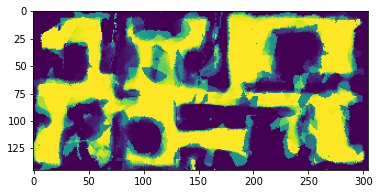

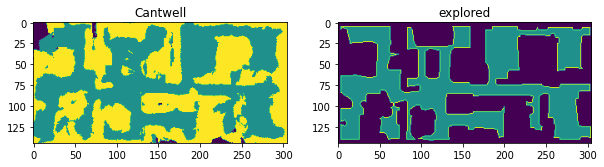

In [70]:
# LOCAL_MAP_DIR  = "/scratch/shantanu/results_23022022/occant_rgb/dump/0/"+scene+"/front/bev_pred"
LOCAL_MAP_DIR  = "/scratch/shantanu/final_results/gibson4/basic_transformer2/"+scene+"/front"
POSE_DIR  = "/scratch/shantanu/gibson4/new/"+scene+"/0/front/pose"
GT_MAP_DIR  = "/scratch/shantanu/gibson4/new/"+scene+"/0/front/map"

PROB_DIR = "/scratch/shantanu/final_results/gibson4/basic_transformer2/"+scene+"/front/prob"

trajectory_agent = []
top_down_map = make_global_map(sim)
grid_dimension = (top_down_map.shape[0],top_down_map.shape[1])

m = register_all_observations()
trajectory_agent = np.array(trajectory_agent,dtype=np.int8)


m_th = m
plt.figure()
plt.imshow(m[0])

# m_th = m_th < MAP_THRESHOLD
m_th = m_th < 0.4


occ_map = np.zeros(m.shape)

occ_map[0] = (127.0*(1-m_th[0]) + 254.0*(m_th[0]))*(1-m_th[1])
# plt.figure()
# plt.imshow(occ_map[0])

fig = plt.figure(figsize=(10,15))
ax1 = fig.add_subplot(1,2,1)
ax1.title.set_text(scene)
# ax1.imshow(m_th[0],interpolation=None)
ax1.imshow(occ_map[0],interpolation=None)

# ax2 = fig.add_subplot(2,1,2)
# ax2.title.set_text('ground truth')
# ax2.plot(trajectory_agent[:,0],trajectory_agent[:,1],c='r',marker='o')
# ax2.imshow(top_down_map)
ax2 = fig.add_subplot(1,2,2)
ax2.title.set_text('explored')
ax2.imshow(top_down_map)




I0228 18:15:45.053401 2675 simulator.py:221] Loaded navmesh /scratch/jd_entropy_ma_reg/entropy_moving_average_global_maps/gibson/Eastville.navmesh
I0228 18:15:49.843038 2675 simulator.py:221] Loaded navmesh /scratch/jd_entropy_ma_reg/entropy_moving_average_global_maps/gibson/Sands.navmesh
I0228 18:15:51.283432 2675 simulator.py:221] Loaded navmesh /scratch/jd_entropy_ma_reg/entropy_moving_average_global_maps/gibson/Pablo.navmesh
I0228 18:15:53.222928 2675 simulator.py:221] Loaded navmesh /scratch/jd_entropy_ma_reg/entropy_moving_average_global_maps/gibson/Elmira.navmesh
I0228 18:15:58.012420 2675 simulator.py:221] Loaded navmesh /scratch/jd_entropy_ma_reg/entropy_moving_average_global_maps/gibson/Ribera.navmesh
I0228 18:15:59.479789 2675 simulator.py:221] Loaded navmesh /scratch/jd_entropy_ma_reg/entropy_moving_average_global_maps/gibson/Edgemere.navmesh
I0228 18:16:03.758510 2675 simulator.py:221] Loaded navmesh /scratch/jd_entropy_ma_reg/entropy_moving_average_global_maps/gibson/Sist

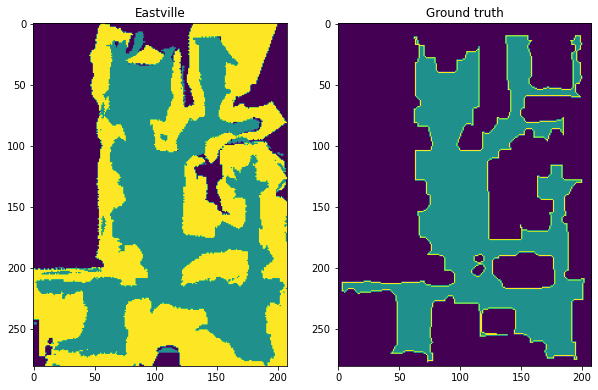

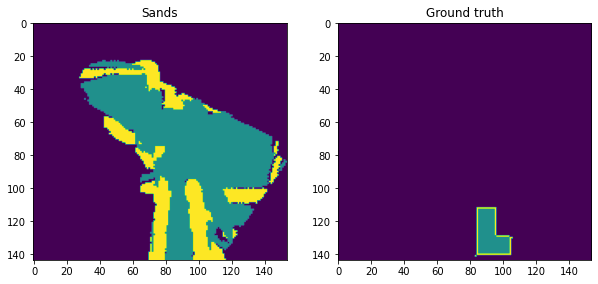

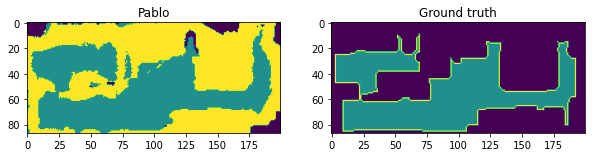

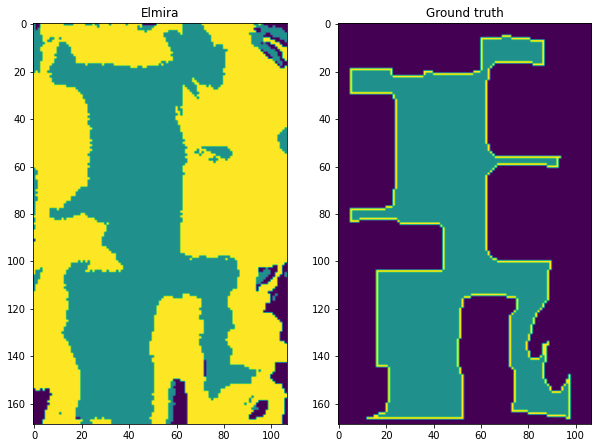

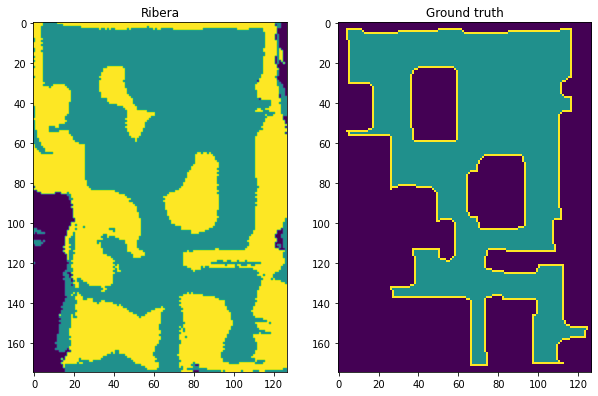

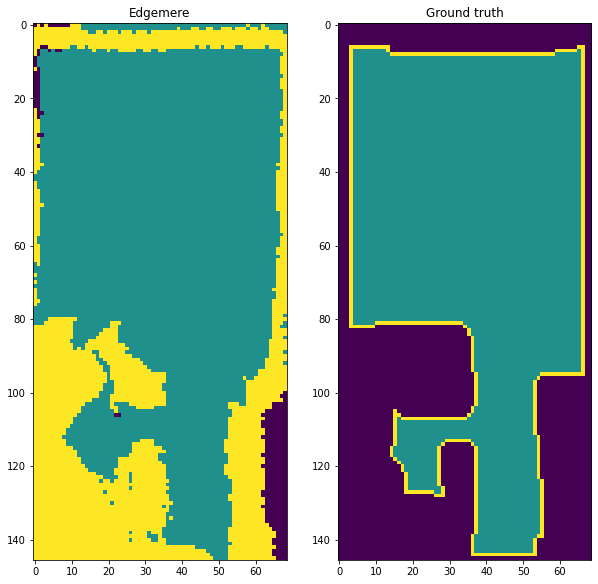

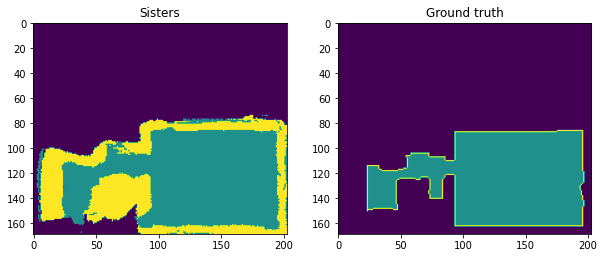

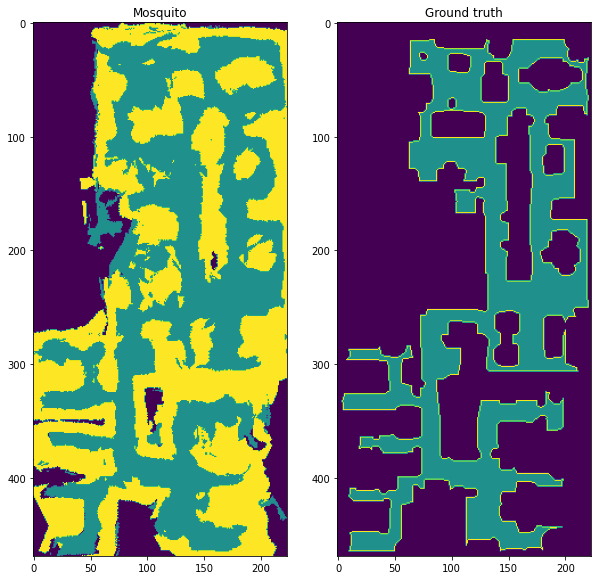

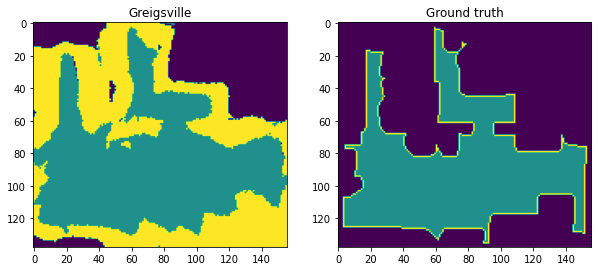

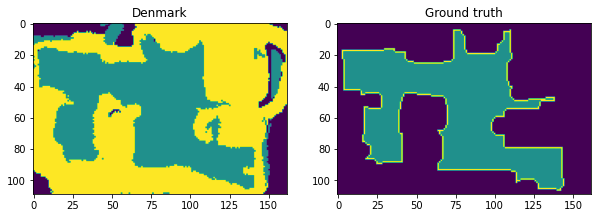

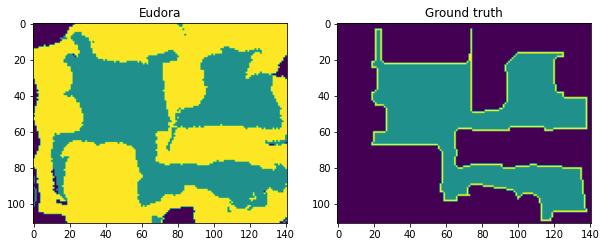

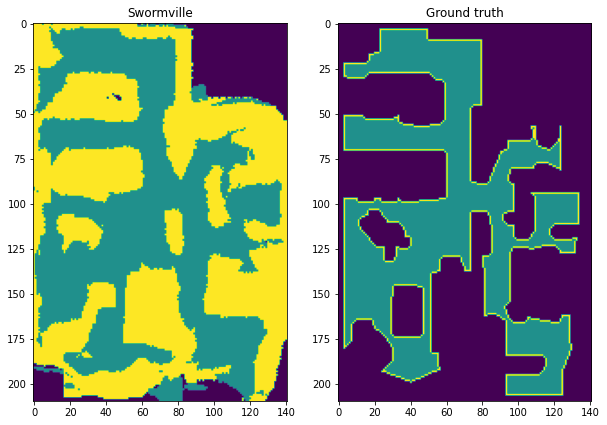

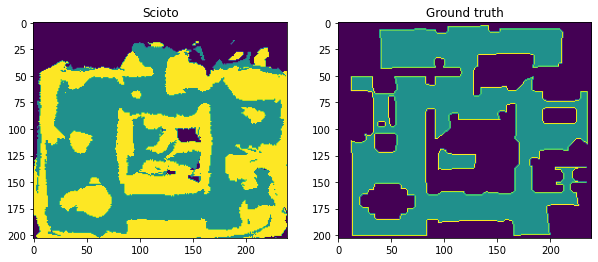

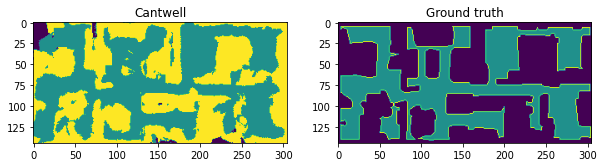

In [75]:
validation_scenes =  os.listdir("/scratch/shantanu/final_results/gibson4/basic_transformer2/")



# for scene in validation_scenes:
for scene in validation_scenes:
#     path = "/scratch/entropy_moving_average_global_maps/gibson"
    path = "/scratch/jd_entropy_ma_reg/entropy_moving_average_global_maps/gibson"
#     scene = "Pablo"
    if sim != None:
        sim.close()
    sim = make_sim(path,scene)

    LOCAL_MAP_DIR  = "/scratch/shantanu/final_results/gibson4/basic_transformer2/"+scene+"/front"
    POSE_DIR  = "/scratch/shantanu/gibson4/new/"+scene+"/0/front/pose"
    GT_MAP_DIR  = "/scratch/shantanu/gibson4/new/"+scene+"/0/front/map"

    PROB_DIR = "/scratch/shantanu/final_results/gibson4/basic_transformer2/"+scene+"/front/prob"

    top_down_map = make_global_map(sim)
    grid_dimension = (top_down_map.shape[0],top_down_map.shape[1])
    
    m = register_all_observations()
    m_th = m
    m_th = m_th < 0.4
    
    occ_map = np.zeros(m.shape)

    occ_map[0] = (127.0*(1-m_th[0]) + 254.0*(m_th[0]))*(1-m_th[1])

    fig = plt.figure(figsize=(10,15))
    ax1 = fig.add_subplot(1,2,1)
    ax1.title.set_text(scene)
    # ax1.imshow(m_th[0],interpolation=None)
    ax1.imshow(occ_map[0],interpolation=None)

    # ax2 = fig.add_subplot(2,1,2)
    # ax2.title.set_text('ground truth')
    # ax2.plot(trajectory_agent[:,0],trajectory_agent[:,1],c='r',marker='o')
    # ax2.imshow(top_down_map)
    ax2 = fig.add_subplot(1,2,2)
    ax2.title.set_text('Ground truth')
    ax2.imshow(top_down_map)
    

#     fig = plt.figure(figsize=(10,15))
#     ax1 = fig.add_subplot(2,1,1)
#     ax1.title.set_text(scene)
#     ax1.imshow(m_th[0],interpolation=None)
# #     fig.colorbar()
#     ax2 = fig.add_subplot(2,1,2)
#     ax2.title.set_text('ground truth')
#     ax2.imshow(top_down_map)

#     fig.savefig('/scratch/entropy_moving_average_global_maps/Results/'+scene+'.png')
    fig.savefig('/scratch/jd_entropy_ma_reg/entropy_moving_average_global_maps/Results/'+scene+'.png')
    



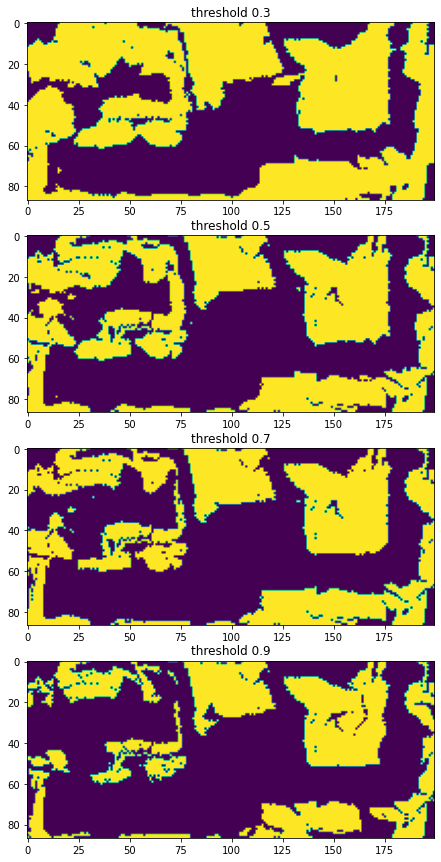

In [10]:
plt.figure(figsize=(10,15))
m = register_all_observations()

map_th = 0.3
m_th = m
m_th = m_th > map_th
plt.subplot(4,1,1)
plt.title('threshold 0.3')
plt.imshow(m_th[0],interpolation=None)


map_th = 0.5
m_th = m
m_th = m_th > map_th
plt.subplot(4,1,2)
plt.title('threshold 0.5')
plt.imshow(m_th[0],interpolation=None)

map_th = 0.7
m_th = m
m_th = m_th > map_th
plt.subplot(4,1,3)
plt.title('threshold 0.7')
plt.imshow(m_th[0],interpolation=None)

map_th = 0.9
m_th = m
m_th = m_th > map_th
plt.subplot(4,1,4)
plt.title('threshold 0.9')
plt.imshow(m_th[0],interpolation=None)

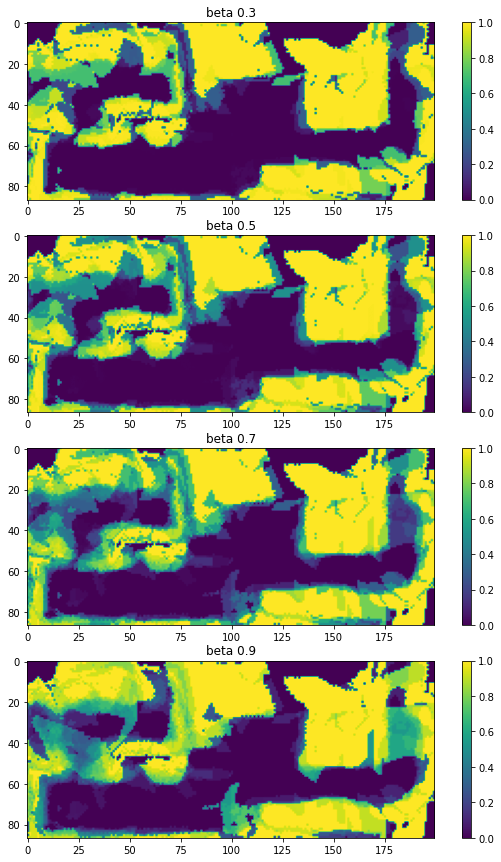

In [193]:
plt.figure(figsize=(10,15))
beta = 0.3
m = register_all_observations()
plt.subplot(4,1,1)
plt.title('beta 0.3')
plt.imshow(m[0],interpolation=None)
plt.colorbar()

beta = 0.5
m = register_all_observations()
plt.subplot(4,1,2)
plt.title('beta 0.5')
plt.colorbar()
plt.imshow(m[0],interpolation=None)

beta = 0.7
m = register_all_observations()
plt.subplot(4,1,3)
plt.title('beta 0.7')
plt.colorbar()
plt.imshow(m[0],interpolation=None)

beta = 0.9
m = register_all_observations()
plt.subplot(4,1,4)
plt.title('beta 0.9')
plt.colorbar()
plt.imshow(m[0],interpolation=None)

# plt.imshow(top_down_map,interpolation=None)

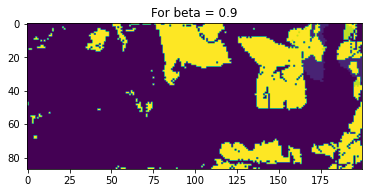

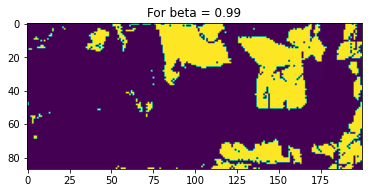

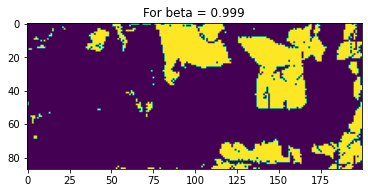

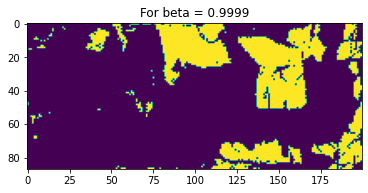

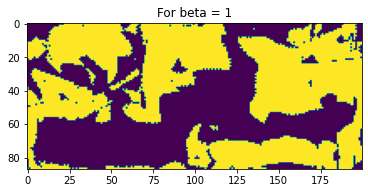

In [131]:
for b in [0.9,0.99,0.999,0.9999,1]:
    beta = b
    m = register_all_observations()
    plt.figure()
    plt.title('For beta = '+str(b))
    plt.imshow(m[0],interpolation=None)
    
#     plt.imshow(top_down_map,interpolation=None)

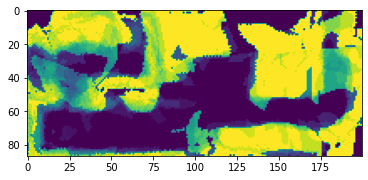

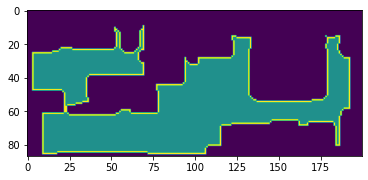

In [180]:
plt.imshow(m[0],interpolation=None)
plt.figure()
plt.imshow(top_down_map,interpolation=None)

In [ ]:
# LOCAL_MAP_DIR  = "/scratch/shantanu/results_23022022/occant_rgb/dump/0/Cantwell/front/bev_pred"
# POSE_DIR  = "/scratch/shantanu/gibson4/new/Cantwell/0/front/pose"
# # POSE_DIR  = "/scratch/shantanu/gibson4/new/Cantwell/0/front/map"

# top_down_map = make_global_map(sim)
# grid_dimension = (top_down_map.shape[0],top_down_map.shape[1])

# def register_all_observations():
#     m = np.zeros((2,grid_dimension[0],grid_dimension[1]))
#     local_maps = os.listdir(LOCAL_MAP_DIR)
#     local_maps = sorted(local_maps, key=lambda x: int(x.split('.')[0]))
#     for local_map in local_maps[3:4]:
    
#         # LOADING AND PADDING LOCAL MAP
#         p_org = cv2.imread(LOCAL_MAP_DIR+'/'+local_map,-1)
#         p = cv2.resize(p_org,(64,64))
#         V = p.shape[1]
# #         print(np.sum(p==0))
#         unknown_p = (1-(p==0.0))
# #         plt.figure()
# #         plt.imshow(unknown_p)
#         p_reg = np.zeros((2,V,V))
#         p_reg[0] = p
#         p_reg[1] = unknown_p
        
# #         print(np.unique(p))
# #         print(np.unique(p_reg[1]))
#         pixel_coordinates,p_reg = get_padded_map(m,p_reg)
# #         print(pixel_coordinates)
# #         plt.figure()
# #         plt.imshow(p_reg[0])
        
        
        
#         # Get 3D poses in local frame
        
#         pixel_3d = np.array([[0,0,0,1],
#                          [0,0,-32*0.05,1],
#                          [64*0.05,0,-32*0.05,1]])
        
        
# #         pixel_3d = np.array([[0,0,0,1],
# #                          [-32*0.05,0,0,1],
# #                          [-32*0.05,0,64*0.05,1]])
#         scan = local_map.split('.')[0]
# #         print(scan)
#         pose = np.load(POSE_DIR+'/'+scan+'.npy',allow_pickle=True).item()
#         quat = pose['rotation']
#         R = quaternion.as_rotation_matrix(quat)
#         t = pose['position']
#         T = np.zeros((4,4))
#         T[:3,:3] = R
#         T[:3,3] = t
#         T[3,3] = 1
        
#         local_3d = np.empty((3,3))
#         for i,pnt in enumerate(pixel_3d):
#             p_ = np.matmul(T,pnt)
#             p_/=p_[-1]
#             local_3d[i,:] = p_[:3]
        
# #         print("l3d",local_3d)
# #         print("pose: ",pose)
#         # WE HAVE THE LOCAL 3D COORDINATES NOW
        
#         map_coord = np.empty((3,2),dtype=np.float32)
#         for i,pnt in enumerate(local_3d):
#             mp = to_map_coord(sim,pnt, grid_dimension)
#             map_coord[i,:] = mp
# #         print(map_coord)
# #         print(np.round(local_3d,2))
#         # WE HAVE THE PIXEL CORRESPONDING COORDINATED NOW
        
#         # CALCULATE AFFINE MATRIX AND TRANSFORM LOCAL TO GLOBAL
# #         print(type(pixel_coordinates[0][0]),pixel_coordinates.shape)
#         pixel_coordinates = pixel_coordinates[:, [1, 0]]
#         map_coord = map_coord[:, [1, 0]]



#         M = cv2.getAffineTransform(pixel_coordinates, map_coord)
# #         M = cv2.getAffineTransform(pixel_coordinates , map_coord)
# #         print(M)
#         p_tran = np.zeros((2,grid_dimension[1],grid_dimension[0]))
#         p_tran[0]= cv2.warpAffine(p_reg[0]*255,
#                                   M,
#                                   (grid_dimension[1],grid_dimension[0])).T
# #         p_tran[1]= cv2.warpAffine(p_reg[1]*255, M,grid_dimension).T
        
        
# #         plt.figure()
        
#         m = aggregate(m,p_tran)
# #         print(p_reg.shape)
# #         top_down_map[int(map_coord[0][0]):int(map_coord[0][0])+2,int(map_coord[0][1]):int(map_coord[0][1])+2] = 2 
        
# #         plt.figure()
# #         plt.imshow(p_reg[0])
# #         plt.imshow(p_tran[1])
# #         plt.figure()
# #         plt.imshow(p_org)
# #         plt.figure()
# #         plt.imshow()
# #         plt.imshow(p_tran[0])
# #         plt.imshow(top_down_map)
        
#     return m
# m = register_all_observations()